In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import re
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from text_generator import TextGenerator
from robust_text_generator import RobustTextImageGenerator
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.regularizers import l2


import re
from typing import List, Dict, Tuple

print("🍷 WINE OCR LEARNING LAB - STUDENT VERSION")
print("Your mission: Fill in the missing code to build a complete system!")

# =============================================================================
# 1. CONSTS
# =============================================================================

VOCABULARY_MAX_SIZE = 100000  # Adjust as needed

MENU_CHARACTERS = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.,-*'&$%"

#(
    
#     "0123456789" +           # Years, prices
#     "ABCDEFGHIJKLMNOPQRSTUVWXYZ" +  # Wine names (caps)
#     "abcdefghijklmnopqrstuvwxyz" +  # Wine names (lowercase)
#     " .,-*'&$%"                 # Punctuation
# )


char_to_idx = {char: idx for idx, char in enumerate(MENU_CHARACTERS)}
idx_to_char = {idx: char for idx, char in enumerate(MENU_CHARACTERS)}





🍷 WINE OCR LEARNING LAB - STUDENT VERSION
Your mission: Fill in the missing code to build a complete system!


In [8]:
def ocr_cnn(img_width, img_height, output_size):
    
    model = keras.Sequential([
        Input(shape=(img_width * img_height,)),
        Dense(128, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    return model

In [9]:
def detect_text_regions_aggressive(image_path):
  """More aggressive text detection"""
  img = cv2.imread(image_path)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  # Try multiple approaches
  regions = []
  
  # Method 1: MSER (good for text)
  mser = cv2.MSER_create()
  regions_mser, _ = mser.detectRegions(gray)
  
  # Method 2: Threshold + contours
  _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # Method 3: Adaptive threshold
  adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
  contours_adaptive, _ = cv2.findContours(adaptive, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  # Combine all contours
  all_contours = list(contours) + list(contours_adaptive)
  
  for contour in all_contours:
      x, y, w, h = cv2.boundingRect(contour)
      
      # MUCH more relaxed criteria
      if w > 5 and h > 5 and w < img.shape[1]*0.8 and h < img.shape[0]*0.8:
          regions.append((x, y, x+w, y+h))
  
  print(f"Found {len(regions)} regions with aggressive detection")
  return regions

# Test aggressive detection


def detect_text_regions(image_path):
    """Find all text regions in wine menu image"""
    
    print(f"🔍 Detecting text regions in {image_path}")
    
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ Could not load image: {image_path}")
        return [], None
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours (potential text regions)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    text_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter by size - adjust these values based on your wine menu
        # Text lines are usually: wide but not too tall
        if w > 50 and h > 10 and w < 800 and h < 60:
            text_boxes.append({
                'x': x,
                'y': y,
                'width': w,
                'height': h
            })
    
    # Sort by position (top to bottom, then left to right)
    text_boxes = sorted(text_boxes, key=lambda box: (box['y'], box['x']))
    
    print(f"✅ Found {len(text_boxes)} potential text regions")
    return text_boxes, image
    
def segment_characters_in_region(text_region_image):
    """Segment a text region into individual character images"""
    
    # Convert to grayscale if needed
    if len(text_region_image.shape) == 3:
        gray = cv2.cvtColor(text_region_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = text_region_image
    
    # Apply threshold to get binary image
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Find character contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours left to right
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    character_images = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter noise (too small)
        if w > 3 and h > 5:
            # Extract character
            char_img = binary[y:y+h, x:x+w]
            
            # Resize to match your training data (32x48)
            char_img_resized = cv2.resize(char_img, (32, 48))
            
            # Normalize to match training format
            char_img_normalized = char_img_resized.astype(np.float32) / 255.0
            
            character_images.append(char_img_normalized)
    
    return character_images


def recognize_text_with_cnn(text_region_image, cnn_model, char_to_idx, idx_to_char):
    """Use your trained CNN to recognize text in a region"""
    
    # Segment into characters
    character_images = segment_characters_in_region(text_region_image)
    
    if len(character_images) == 0:
        return ""
    
    # Recognize each character
    recognized_text = ""
    
    for char_img in character_images:
        # Flatten for your Dense model
        char_input = char_img.flatten().reshape(1, -1)
        
        # Predict with your CNN
        prediction = cnn_model.predict(char_input, verbose=0)
        predicted_idx = np.argmax(prediction[0])
        predicted_char = idx_to_char[predicted_idx]
        
        recognized_text += predicted_char
    
    return recognized_text



def extract_all_spatial_text_cnn(image, text_boxes, cnn_model, char_to_idx, idx_to_char):
    """Extract text using your CNN model"""
    
    print("🔤 Extracting text with CNN model...")
    
    spatial_text = []
    
    for i, box in enumerate(text_boxes):
        # Extract the region
        x, y, w, h = box['x'], box['y'], box['width'], box['height']
        text_region = image[y:y+h, x:x+w]
        
        # Use CNN to recognize text
        recognized_text = recognize_text_with_cnn(text_region, cnn_model, char_to_idx, idx_to_char)
        
        # Store with spatial info
        spatial_text.append({
            'text': recognized_text,
            'x': box['x'],
            'y': box['y'],
            'width': box['width'],
            'height': box['height'],
            'box_id': i
        })
        
        print(f"  Box {i}: '{recognized_text}' at ({box['x']}, {box['y']})")
    
    return spatial_text



def visualize_text_detection(image, text_boxes, save_path=None):
    """Show detected text regions"""
    if image is None:
        print(f"❌ Could not load image")
        return [], None

    # Create copy for drawing
    result_image = image.copy()
    
    # Draw bounding boxes
    for i, box in enumerate(text_boxes):
        x, y, w, h = box['x'], box['y'], box['width'], box['height']
        
        # Draw green rectangle
        cv2.rectangle(result_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Add box number
        cv2.putText(result_image, str(i), (x, y-5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    
    # Display
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Text Regions ({len(text_boxes)} boxes)")
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    
    # Print details
    print("📋 Text Box Details:")
    for i, box in enumerate(text_boxes[:10]):  # Show first 10
        print(f"  Box {i}: x={box['x']}, y={box['y']}, size={box['width']}×{box['height']}")


In [10]:
IMG_WIDTH=32
IMG_HEIGHT=32

X shape: (63000, 1024)
X flattened shape: (63000, 1024)
✅ Batch generated, X: (63000, 1024), y: (63000, 70)
   Y1: 0, 0, [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
   Y2: 0, 0, [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
🔍 DATA VERIFICATION:
Total samples: 50400
Expected: 70 × 100 = 7000
Unique classes: 70
Samples per class: min=687, max=762, avg=720.0


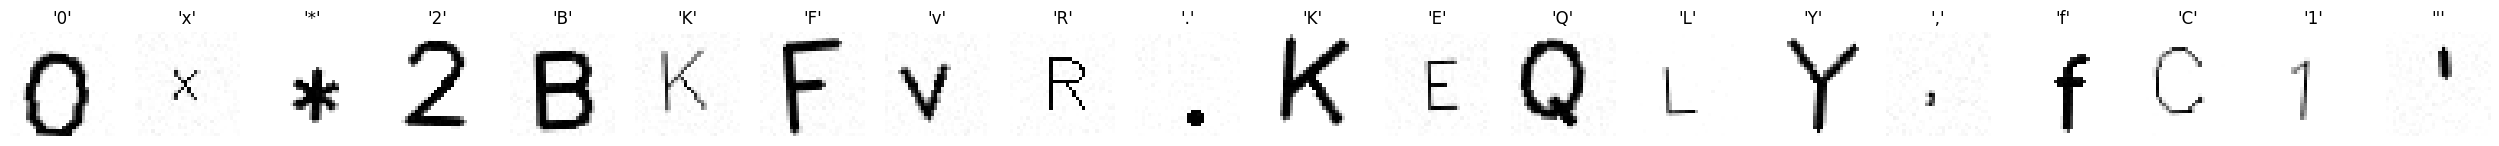

In [11]:

# Generate 100 samples PER character (not 2000 total)
all_X = []
all_y = []
font_sizes = [11, 12, 13, 14, 16, 18, 20, 22, 24]
generator = RobustTextImageGenerator(IMG_WIDTH, IMG_HEIGHT)

for size in font_sizes:
    for char in MENU_CHARACTERS:
        for i in range(100):  # 100 samples of EACH character
            img = generator.create_text_image(char, size, None, True)
            
            # if img.max() <= 1.0:
            #     # If values are 0-1, scale to 0-255
            #     img = (img * 255).astype(np.uint8)

            # pil_img = Image.fromarray(img)
            # pil_img.show()
            all_X.append(img.flatten())
            all_y.append(char)

    
X = np.array(all_X)
y = np.array(all_y)

# fig, axes = plt.subplots(3, 4, figsize=(8, 6))
# axes = axes.flatten()

# for i in range(min(12, len(X))):
#     # Reshape flattened image back to 2D
#     img = X[i].reshape((IMG_WIDTH, IMG_WIDTH))
    
#     # Get label
#     char = y[i] if isinstance(y[i], str) else y[i][0]  # Handle different y formats
    
#     # Plot
#     axes[i].imshow(img, cmap='gray')
#     axes[i].set_title(f"'{char}'")
#     axes[i].axis('off')

# plt.tight_layout()
# plt.show()


# fig, axes = plt.subplots(1, 10, figsize=(5, 5))
# for i in range(10):

#    j = np.random.randint(0, len(y))
#    img = X[j].reshape(IMG_HEIGHT, IMG_WIDTH)
    
#    # Get image and label
    
#    char = y[j][0]
#   #  pil_image = Image.fromarray(img)
#   #  pil_image.show(char)  # Show image with font size as title

#    plt.figure(figsize=(6, 8))
#    plt.imshow(img, cmap='gray')
#    plt.title(f"Raw Image of '{char}' - Shape: {img.shape}")
#    plt.colorbar()  # Shows the value scale
#    plt.show()
    
# plt.subplots_adjust(hspace=0.3, wspace=0.2)
# plt.tight_layout(pad=2.0)
# plt.show()



X = np.array(X)
print(f"X shape: {X.shape}")

X_flattened = X.reshape(X.shape[0], -1) / 255.0  # FLatten & Normalize to 0-1 range

# X_flattened = np.array([r[0].flatten().reshape(1, -1) for r in X])
print(f"X flattened shape: {X_flattened.shape}")

y_encoded = np.array([char_to_idx[c] for c in y])

# one-hot now
y_categorical = to_categorical(y_encoded, num_classes=len(MENU_CHARACTERS))

print(f"✅ Batch generated, X: {X_flattened.shape}, y: {y_categorical.shape}")
print(f"   Y1: {y[0]}, {y_encoded[0]}, {y_categorical[0]}")
print(f"   Y2: {y[1]}, {y_encoded[1]}, {y_categorical[1]}")

X_train, X_val, y_train, y_val = train_test_split(
    X_flattened, y_categorical,
    test_size=0.2,      # 20% for validation
    random_state=1,    # Reproducible results
    # stratify=y_encoded  # Equal representation of each character
)

print("🔍 DATA VERIFICATION:")
print(f"Total samples: {len(X_train)}")
print(f"Expected: {len(MENU_CHARACTERS)} × 100 = {len(MENU_CHARACTERS) * 100}")

# Check label distribution
y_labels = np.argmax(y_train, axis=1)
unique, counts = np.unique(y_labels, return_counts=True)
print(f"Unique classes: {len(unique)}")
print(f"Samples per class: min={min(counts)}, max={max(counts)}, avg={np.mean(counts):.1f}")

# Are all classes represented?
if len(unique) != len(MENU_CHARACTERS):
    print(f"⚠️  Missing classes! Expected {len(MENU_CHARACTERS)}, got {len(unique)}")


fig, axes = plt.subplots(1, 20, figsize=(32, 2))

for i in range(20):
   # Get image and label
   img = X_train[i].reshape(IMG_HEIGHT, IMG_WIDTH)
   label_idx = np.argmax(y_train[i])
   char = idx_to_char[label_idx]
    
   # Show image with character as title
   axes[i].imshow(img, cmap='gray')
   axes[i].set_title(f"'{char}'")
   axes[i].axis('off')

plt.show()

# label_counts = np.bincount(np.argmax(y_train, axis=1))
# print("Label distribution:")
# for i, count in enumerate(label_counts):
#     if count > 0:
#         print(f"  '{idx_to_char[i]}': {count} samples")

# # Are labels balanced?
# if max(label_counts) > min(label_counts[label_counts > 0]) * 10:
#     print("⚠️  Very imbalanced labels!")


# Visualize samples
# print("\n📊 Visualizing samples...")

In [12]:
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)
print("First 10 y values:", y_train[:10])
print("Unique y values:", np.unique(y_train))
print("len(MENU_CHARACTERS):", len(MENU_CHARACTERS))
print("MAX", X_train.max())

# # 1. Class distribution
# labels = np.argmax(y_train, axis=1)
# unique, counts = np.unique(labels, return_counts=True)

# plt.figure(figsize=(15, 10))

# plt.subplot(2, 3, 1)
# plt.bar(unique, counts)
# plt.title('Class Distribution')
# plt.xlabel('Class')
# plt.ylabel('Count')

# # 2. Pixel value distribution
# plt.subplot(2, 3, 2)
# plt.hist(X_train.flatten(), bins=50)
# plt.title('All Pixel Values')
# plt.xlabel('Pixel Value')

# # 3. Sample means
# sample_means = np.mean(X_train, axis=1)
# plt.subplot(2, 3, 3)
# plt.hist(sample_means, bins=50)
# plt.title('Mean per Image')
# plt.xlabel('Mean Pixel Value')

# # 4. Sample variance
# sample_vars = np.var(X_train, axis=1)
# plt.subplot(2, 3, 4)
# plt.hist(sample_vars, bins=50)
# plt.title('Variance per Image')
# plt.xlabel('Variance')

# # 5. Feature variance
# feature_vars = np.var(X_train, axis=0)
# plt.subplot(2, 3, 5)
# plt.hist(feature_vars, bins=50)
# plt.title('Feature Variance')
# plt.xlabel('Variance')

# # 6. First few sample images
# plt.subplot(2, 3, 6)
# img_size = int(np.sqrt(X_train.shape[1]))
# img = X_train[0].reshape(img_size, img_size)
# plt.imshow(img, cmap='gray')
# plt.title(f'Sample Image\nClass: {labels[0]}')

# plt.tight_layout()
# plt.show()

# # Print stats
# print(f"X shape: {X_train.shape}")
# print(f"Pixel range: {X_train.min():.3f} to {X_train.max():.3f}")
# print(f"Mean: {X_train.mean():.3f}")
# print(f"Classes: {len(unique)}")
# print(f"Samples per class: {counts}")


y_train shape: (50400, 70)
y_train dtype: float64
First 10 y values: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [13]:

# generator.visualize_samples(X[20:40], y)
# X_train = X_train[:100]  # 10 per class
# y_train = y_train[:100]

# simple_model = keras.Sequential([
#     Input(shape=(1024,)),
#     Dense(512, activation='relu'),
#     Dropout(0.3),
#     Dense(256, activation='relu'),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dense(70, activation='softmax')
# ])


# simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # 2. Train on small batch to test overfitting
# # X_small = X_train[:200]  # 20 samples per class
# # y_small = y_train[:200]

# history = simple_model.fit(X_train, y_train, epochs=200, verbose=1)
# print(f"Final accuracy: {history.history['accuracy'][-1]:.3f}")



In [14]:


# cnn_model = ocr_cnn(IMG_WIDTH, IMG_HEIGHT, len(MENU_CHARACTERS))

cnn_model = keras.Sequential([
    # Input(shape=(X_train.shape[1],)),
    Input(shape=(IMG_WIDTH, IMG_HEIGHT,1)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(MENU_CHARACTERS), activation='softmax')
])

cnn_model.summary()

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
X_train = X_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 1)
# cnn_model.summary()
cnn_model.fit(X_train, y_train, epochs=5, validation_split=0.2)
    
    # for char in ['A', 'B', '1', '2', '0', 'y']:
    #     # Make test image
    #     test_img = generator.create_text_image(char)
    #     test_input = test_img.flatten().reshape(1, -1)
    #     # Predict
    #     prediction = cnn_model.predict(test_input, verbose=0)
    #     # print("prediction", prediction)
    #     predicted_char = idx_to_char[np.argmax(prediction)]
    #     # Result
    #     result = "✅" if predicted_char == char else "❌"
    #     print(f"  {result} '{char}' → '{predicted_char}'")


2025-07-11 13:03:18.051837: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         4,550 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,886 (667.52 KB)

 Trainable params: 170,886 (667.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3514 - loss: 2.5545 - val_accuracy: 0.8773 - val_loss: 0.3554
Epoch 2/5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8965 - loss: 0.2894 - val_accuracy: 0.9251 - val_loss: 0.1885
Epoch 3/5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9334 - loss: 0.1713 - val_accuracy: 0.9137 - val_loss: 0.2148
Epoch 4/5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9422 - loss: 0.1382 - val_accuracy: 0.9469 - val_loss: 0.1204
Epoch 5/5
1260/1260 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9526 - loss: 0.1135 - val_accuracy: 0.9429 - val_loss: 0.1464


In [18]:
import numpy as np
import tensorflow as tf
import random

def prepare_wine_menu_training_data(vectorizer, n_wines=30, max_distance=200, output_length=5):
    """
    Generate wine menu data and return X, y ready for neural network training.
    
    Args:
        n_wines: Number of wine entries to generate
        max_distance: Skip pairs beyond this pixel distance
        output_length: TextVectorization sequence length
    
    Returns:
        X: Feature matrix (n_pairs, n_features) ready for NN
        y: Labels (n_pairs,) - 1 if same group, 0 if different groups
    """
    
    # 1. Generate wine menu data
    vintages = ['2018', '2019', '2020', '2021', '2022', '2023', 'NV']
    producers = ['PENFOLDS', 'NAUTILUS', 'CLOUDY BAY', 'WOLF BLASS', 'HARDYS', 'LINDEMANS']
    white_varietals = ['Sauvignon Blanc', 'Chardonnay', 'Riesling', 'Pinot Grigio']
    red_varietals = ['Shiraz', 'Cabernet Sauvignon', 'Merlot', 'Pinot Noir']
    regions = ['Barossa Valley', 'Hunter Valley', 'Margaret River', 'Marlborough NZ']
    
    col_positions = {'vintage': 50, 'producer': 120, 'varietal': 280, 'region': 450, 'price': 620}
    start_y, row_height = 150, 35
    
    tokens = []
    true_groups = []
    
    # Generate wine tokens
    for wine_idx in range(n_wines):
        y_pos = start_y + (wine_idx * row_height) + random.randint(-3, 3)
        
        vintage = random.choice(vintages)
        producer = random.choice(producers)
        varietal = random.choice(red_varietals if random.choice([True, False]) else white_varietals)
        region = random.choice(regions)
        price = str(random.randint(25, 150))
        
        wine_tokens = [
            {'text': vintage, 'x': col_positions['vintage'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11},
            {'text': producer, 'x': col_positions['producer'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 13},
            {'text': varietal, 'x': col_positions['varietal'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11},
            {'text': region, 'x': col_positions['region'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 9},
            {'text': price, 'x': col_positions['price'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11}
        ]
        
        tokens.extend(wine_tokens)
        true_groups.extend([wine_idx] * len(wine_tokens))
    
    print(f"Generated {len(tokens)} tokens for {n_wines} wines")
    
    # 2. Create TextVectorization
    all_texts = [token['text'] for token in tokens]
    vectorizer.adapt(all_texts)
    text_vectors = vectorizer(all_texts).numpy()
    
    # 3. Create pairwise features and labels
    features = []
    labels = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        for j in range(i + 1, n_tokens):
            token1, token2 = tokens[i], tokens[j]
            
            # Distance check
            x_diff = abs(token1['x'] - token2['x'])
            y_diff = abs(token1['y'] - token2['y'])
            euclidean_dist = np.sqrt(x_diff**2 + y_diff**2)
            
            if euclidean_dist > max_distance:
                continue
            
            # Create features
            t1_text_vector = text_vectors[i]
            t2_text_vector = text_vectors[j]
            
            spatial_features = [
                token1['x'] / 1000.0, token1['y'] / 1000.0, token1['h'] / 100.0,
                token2['x'] / 1000.0, token2['y'] / 1000.0, token2['h'] / 100.0,
                x_diff / 1000.0, y_diff / 1000.0, euclidean_dist / 1000.0,
                float(y_diff < 20), 1.0 if token1['x'] < token2['x'] else -1.0
            ]
            
            pair_features = np.concatenate([t1_text_vector, t2_text_vector, spatial_features])
            features.append(pair_features)
            
            # Create label (1 if same group, 0 if different)
            same_group = (true_groups[i] == true_groups[j])
            labels.append(int(same_group))
    
    X = np.array(features)
    y = np.array(labels)
    
    print(f"Created {X.shape[0]} pairs with {X.shape[1]} features each")
    print(f"Positive pairs (same group): {np.sum(y)} ({np.mean(y):.2%})")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print("Ready for training!")
    
    return X, y

# Example usage
# if __name__ == "__main__":
#     # Get training data
#     X, y = prepare_wine_menu_training_data(n_wines=20)
    
#     # Train your model
#     from sklearn.model_selection import train_test_split
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
#     model = tf.keras.Sequential([
#         tf.keras.layers.Dense(128, input_shape=(X.shape[1],), activation='relu'),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])
    
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     print(f"\nTraining model...")
#     history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)
    
#     print(f"\nTest accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]:.4f}")

In [ ]:
from token_extractor import TokenExtractor
from token_enrichor import TokenEnrichor




vectorizer = tf.keras.layers.TextVectorization(
  max_tokens=VOCABULARY_MAX_SIZE,
  output_sequence_length=1,  # Single token per text
  output_mode='int'
)


def create_pairwise_features(tokens, vectorizer, max_distance=200, same_row_threshold=20, embedding_dim=64):
    """
    Create pairwise features from tokens for neural network training.
    
    Args:
        tokens: List of token dictionaries with keys: 'text', 'x', 'y', 'h', 
                'is_vintage', 'is_varietal_red', 'is_varietal_white', 'is_price'
    
    Returns:
        numpy array of shape (n_pairs, n_features) ready for NN training
    """
    

    features = []

    all_texts = [token['text'] for token in tokens]
    
    vectorizer.adapt(all_texts)

    token_ids = vectorizer(all_texts).numpy().flatten()
    embedding = tf.keras.layers.Embedding(
        input_dim=VOCABULARY_MAX_SIZE,
        output_dim=embedding_dim,
        mask_zero=True
    )

    text_embeddings = embedding(token_ids).numpy()

    # Create all pairs
    for i in range(len(tokens)):
      for j in range(i + 1, len(tokens)):
        t1, t2 = tokens[i], tokens[j]

        # Skip if both tokens are vintage or both are varietals
        if 'is_vintage' in t1 and t1['is_vintage'] and 'is_vintage' in t2 and t2['is_vintage']:
          continue

        # Relationship features (7 features)
        x_diff = abs(t1['x'] - t2['x'])
        y_diff = abs(t1['y'] - t2['y'])
        euclidean_dist = np.sqrt(x_diff**2 + y_diff**2)

        if euclidean_dist > max_distance:
            continue  # Skip this pair

        # Token 1 features (7 features)
        t1_features = [
            float(t1.get('is_varietal_red', False)),
            float(t1.get('is_varietal_white', False)),
            float(t1.get('is_price', False)),
            float(t1.get('is_vintage', False)),
            t1['x'] / 1000.0,  # Normalize coordinates
            t1['y'] / 1000.0,
            t1['h'] / 100.0,   # Normalize font height
        ]
        
        # Token 2 features (7 features)
        t2_features = [
            float(t2.get('is_varietal_red', False)),
            float(t2.get('is_varietal_white', False)),
            float(t2.get('is_price', False)),
            float(t2.get('is_vintage', False)),
            t2['x'] / 1000.0,
            t2['y'] / 1000.0,
            t2['h'] / 100.0,
        ]
        
        relationship_features = [
            x_diff / 1000.0,                           # X distance (normalized)
            y_diff / 1000.0,                           # Y distance (normalized)
            euclidean_dist / 1000.0,                   # Euclidean distance (normalized)
            float(y_diff < same_row_threshold),        # Same row (boolean)
            1.0 if t1['x'] < t2['x'] else -1.0, # Left-right order
            abs(t1['h'] - t2['h']) / 100.0,    # Font size difference
            min(t1['h'], t2['h']) / max(t1['h'], t2['h'], 1), # Font size ratio
            t1['text'] == t2['text'] # same
        ]
        
        t1_embed = text_embeddings[i]  # Shape: (embedding_dim,)
        t2_embed = text_embeddings[j]  # Shape: (embedding_dim,)

        # Combine all features (21 total)

        pair_features = np.concatenate([
           t1_embed, 
           t1_features, 
           t2_embed, 
           t2_features,
           relationship_features])

        features.append(pair_features)
    
    return np.array(features)

# Usage
extractor = TokenExtractor(
    low_text=0.3,
    width_ths=0.4,
    height_ths=0.4)

enrichor = TokenEnrichor()

# Example usage and testing
# Generate test data
def prepare_wine_menu_training_data(vectorizer, enrichor, n_wines=30):
   """
   Generate wine menu data and return X, y using create_pairwise_features and enrich_token.
   """
   
   # 1. Generate wine menu data
   vintages = ['2018', '2019', '2020', '2021', '2022', '2023', 'NV']
   producers = ['PENFOLDS', 'NAUTILUS', 'CLOUDY BAY', 'WOLF BLASS', 'HARDYS', 'LINDEMANS']
   white_varietals = ['Sauvignon Blanc', 'Chardonnay', 'Riesling', 'Pinot Grigio']
   red_varietals = ['Shiraz', 'Cabernet Sauvignon', 'Merlot', 'Pinot Noir']
   regions = ['Barossa Valley', 'Hunter Valley', 'Margaret River', 'Marlborough NZ']
   
   col_positions = {'vintage': 50, 'producer': 120, 'varietal': 280, 'region': 450, 'price': 620}
   start_y, row_height = 150, 35
   
   tokens = []
   true_groups = []
   
   # Generate wine tokens
   for wine_idx in range(n_wines):
       y_pos = start_y + (wine_idx * row_height) + random.randint(-3, 3)
       
       vintage = random.choice(vintages)
       producer = random.choice(producers)
       varietal = random.choice(red_varietals if random.choice([True, False]) else white_varietals)
       region = random.choice(regions)
       price = str(random.randint(25, 150))
       
       wine_tokens = [
           {'text': vintage, 'x': col_positions['vintage'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11},
           {'text': producer, 'x': col_positions['producer'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 13},
           {'text': varietal, 'x': col_positions['varietal'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11},
           {'text': region, 'x': col_positions['region'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 9},
           {'text': price, 'x': col_positions['price'] + random.randint(-5, 5), 'y': y_pos + random.randint(-2, 2), 'h': 11}
       ]
       
       tokens.extend(wine_tokens)
       true_groups.extend([wine_idx] * len(wine_tokens))
   
   print(f"Generated {len(tokens)} tokens for {n_wines} wines")
   
   # 2. Enrich tokens using your actual enrich_token function
   tokens = [enrichor.enrich_token(token) for token in tokens]
   
   # 3. Use your actual create_pairwise_features function with same parameters
   X = create_pairwise_features(
       tokens, 
       vectorizer=vectorizer, 
       max_distance=200, 
       same_row_threshold=20, 
       embedding_dim=64
   )
   
   # 4. Create labels using the EXACT same logic as create_pairwise_features
   labels = []
   
   for i in range(len(tokens)):
       for j in range(i + 1, len(tokens)):
           token1, token2 = tokens[i], tokens[j]
           
           # Apply ALL the same filters as create_pairwise_features
           x_diff = abs(token1['x'] - token2['x'])
           y_diff = abs(token1['y'] - token2['y'])
           euclidean_dist = np.sqrt(x_diff**2 + y_diff**2)
           
           # Same distance filter
           if euclidean_dist > 200:  # max_distance
               continue
               
           # Add any other filters that might be in create_pairwise_features
           # (check your function for additional filtering conditions)
           
           # Create label
           same_group = (true_groups[i] == true_groups[j])
           labels.append(int(same_group))
   
   y = np.array(labels)
   
   print(f"Created {X.shape[0]} pairs with {X.shape[1]} features each")
   print(f"Labels created: {len(y)}")
   print(f"Positive pairs (same group): {np.sum(y)} ({np.mean(y):.2%})")
   
   # Verify sizes match
   if X.shape[0] != len(y):
       print(f"❌ Size mismatch! X: {X.shape[0]}, y: {len(y)}")
       print("Check if create_pairwise_features has additional filtering beyond distance")
       # Truncate to match
       min_size = min(X.shape[0], len(y))
       X = X[:min_size]
       y = y[:min_size]
       print(f"✅ Truncated to match: X: {X.shape}, y: {y.shape}")
   else:
       print(f"✅ Perfect match! X: {X.shape}, y: {y.shape}")
   
   print("Ready for training!")
   
   return X, y

# Now train with the exact same pipeline as testing
X, y = prepare_wine_menu_training_data(vectorizer=vectorizer, enrichor=enrichor, n_wines=20)


# Train your model
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = keras.Sequential([
    Input(shape=(X.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'), 
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model
print("\nTraining model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

# Evaluate
print(f"\nTraining model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)

print(f"\nTest accuracy: {model.evaluate(X_test, y_test, verbose=0)[1]:.4f}")

# test
tokens = extractor.extract_tokens('data/menus/menu_test.png')

tokens = [enrichor.enrich_token(token) for token in tokens]

X = create_pairwise_features(tokens, vectorizer=vectorizer)
# You already have:
# tokens = extractor.extract_tokens('data/menus/menu_test.png')
# tokens = [enrich_token(token) for token in tokens]
# X = create_pairwise_features(tokens)

print("🍷 PREDICTING ON REAL MENU DATA")
print("=" * 50)
print(f"📄 {len(tokens)} tokens extracted")
print(f"🔗 {X.shape[0]} pairs created")
print(f"🤖 Making predictions...")

# Make predictions
predictions = model.predict(X, verbose=0).flatten()

# Show prediction stats
same_group = np.sum(predictions > 0.5)
different_group = np.sum(predictions <= 0.5)
print(f"✅ {same_group} pairs predicted as SAME GROUP")
print(f"❌ {different_group} pairs predicted as DIFFERENT GROUP")

# Create adjacency matrix for grouping
n_tokens = len(tokens)
adjacency = np.zeros((n_tokens, n_tokens))

# Fill adjacency matrix from predictions
pair_idx = 0
for i in range(n_tokens):
   for j in range(i + 1, n_tokens):
       # Skip if pair was filtered out during feature creation
       if pair_idx < len(predictions) and predictions[pair_idx] > 0.5:
           adjacency[i][j] = 1
           adjacency[j][i] = 1
       if pair_idx < len(predictions):
           pair_idx += 1

# Find connected components (groups)
visited = [False] * n_tokens
groups = []

def dfs(node, current_group):
   visited[node] = True
   current_group.append(node)
   for neighbor in range(n_tokens):
       if adjacency[node][neighbor] == 1 and not visited[neighbor]:
           dfs(neighbor, current_group)

for i in range(n_tokens):
   if not visited[i]:
       current_group = []
       dfs(i, current_group)
       groups.append(current_group)

# Display results
print(f"\n🔍 DETECTED {len([g for g in groups if len(g) > 1])} WINE GROUPS")
print("=" * 50)

for group_idx, group in enumerate(groups):
   if len(group) == 1:
       continue  # Skip single tokens
       
   print(f"\n🍷 WINE {group_idx + 1}:")
   
   # Sort tokens by x position (left to right)
   group_tokens = [tokens[i] for i in group]
   group_tokens.sort(key=lambda x: x['x'])
   
   wine_text = []
   for token in group_tokens:
       text = token['text']
       if token.get('is_vintage'):
           text += " 🗓️"
       elif token.get('is_varietal_red'):
           text += " 🍷"  
       elif token.get('is_varietal_white'):
           text += " 🥂"
       elif token.get('is_price'):
           text += " 💰"
       wine_text.append(text)
   
   print(f"   {' | '.join(wine_text)}")

# Show top confident predictions
print(f"\n🔍 TOP CONFIDENT PREDICTIONS:")
print("-" * 30)

# Get pair info for top predictions
pair_info = []
pair_idx = 0
for i in range(n_tokens):
   for j in range(i + 1, n_tokens):
       if pair_idx < len(predictions):
           pair_info.append((i, j, predictions[pair_idx]))
           pair_idx += 1

# Sort by confidence
pair_info.sort(key=lambda x: x[2], reverse=True)

print("✅ SAME GROUP (top 5):")
count = 0
for i, j, conf in pair_info:
   if conf > 0.5 and count < 5:
       print(f"   {conf:.3f} | '{tokens[i]['text']}' ↔ '{tokens[j]['text']}'")
       count += 1

print("\n❌ DIFFERENT GROUP (top 5):")
count = 0
for i, j, conf in reversed(pair_info[-10:]):
   if conf < 0.5 and count < 5:
       print(f"   {conf:.3f} | '{tokens[i]['text']}' ✗ '{tokens[j]['text']}'")
       count += 1

print(f"\n🎉 DONE! Found {len([g for g in groups if len(g) > 1])} wines")

Generated 100 tokens for 20 wines
Created 885 pairs with 150 features each
Labels created: 964
Positive pairs (same group): 80 (8.30%)
❌ Size mismatch! X: 885, y: 964
Check if create_pairwise_features has additional filtering beyond distance
✅ Truncated to match: X: (885, 150), y: (885,)
Ready for training!

Training model...
Epoch 1/5


/home/tr/dev/cellar-ai/.venv/lib/python3.12/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6973 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9243 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9302 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9222 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9189 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00

Training model...
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9317 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9233 - loss: 0.0000e+00 - val_accuracy: 0.9096 - val_loss: 0.0000e+00
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

/home/tr/dev/cellar-ai/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🍷 PREDICTING ON REAL MENU DATA
📄 52 tokens extracted
🔗 455 pairs created
🤖 Making predictions...
✅ 0 pairs predicted as SAME GROUP
❌ 455 pairs predicted as DIFFERENT GROUP

🔍 DETECTED 0 WINE GROUPS

🔍 TOP CONFIDENT PREDICTIONS:
------------------------------
✅ SAME GROUP (top 5):

❌ DIFFERENT GROUP (top 5):
   0.000 | '16' ✗ '95'
   0.000 | '16' ✗ '19'
   0.000 | '16' ✗ 'Toscana Italy'
   0.000 | '16' ✗ 'ANTINORI Chianti'
   0.000 | '16' ✗ '2020'

🎉 DONE! Found 0 wines
